# Load dataset

In [22]:
import pandas as pd, numpy as np

df = pd.read_csv("data/processed/phq4_ts_features.csv")

# keep rows that have SRI and at least 7 PHQ-4 observations
df = df.dropna(subset=["SRI"])
valid_pids = df["pid"].value_counts().loc[lambda s: s >= 7].index
df = df[df["pid"].isin(valid_pids)]

# drop very sparse columns (>1000 missing) & keep predictors only
missing = df.isna().sum()
keep_cols = missing[missing < 1000].index.difference(
    ["pid", "PHQ4_date", "PHQ4"]
)
# --- after you load & basic-filter df ---------------------------
df = df.sort_values(["pid", "PHQ4_date"])

# 1. create deviation-from-subject-mean
df["PHQ4_dev"] = df["PHQ4"] - df.groupby("pid")["PHQ4"].transform("mean")

# 2. keep core + Elastic-Net picks, but USE PHQ4_dev instead of PHQ4
circadian_core = ["PHQ4_dev", "SRI", "dlmo_proxy", "sigma_bed", "mid_sleep"]
enet_vars      = pd.read_csv("data/processed/selected_predictors.csv")["PHQ4_dev"]

vars_all = list(dict.fromkeys(circadian_core + enet_vars.tolist()))

vars_all = [v for v in vars_all if v != "PHQ4_dev"] + ["PHQ4_dev"]
p        = len(vars_all)

In [23]:
def zscore_subject(group: pd.DataFrame) -> pd.DataFrame:
    z = group[vars_all].apply(
        lambda v: (v - v.mean()) / (v.std(ddof=0) or 1.0)
    )
    return z.fillna(0)                   # any residual NaN → 0
df_z = df.groupby("pid", sort=False).apply(zscore_subject).reset_index(level=0)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_2402/37686180.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_z = df.groupby("pid", sort=False).apply(zscore_subject).reset_index(level=0)


# GaussianMixture Clustring

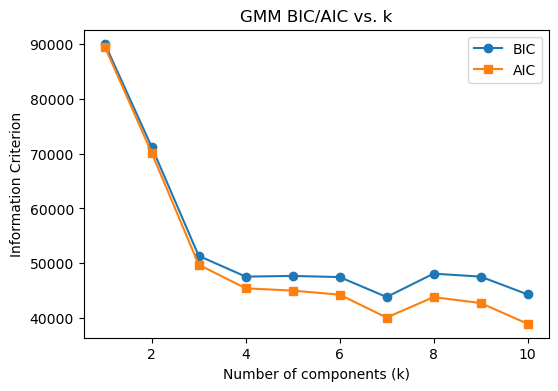

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture   import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import collections

# 1) Define circadian features
cluster_vars = [
    "steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope",
    "steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std",
    "steps_fitbit_steps_intraday_rapids_mindurationactivebout_night_mean",
    "steps_fitbit_steps_intraday_rapids_avgdurationactivebout_allday_std",
    "steps_fitbit_steps_intraday_rapids_avgdurationactivebout_night_slope",
    "steps_fitbit_steps_intraday_rapids_countepisodeactivebout_night_std",
    "steps_fitbit_steps_intraday_rapids_sumdurationactivebout_evening_slope",
    "screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std",
    "screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope",
]

# 2) Determine T = minimum # of observations per subject
obs_per_pid = df.groupby("pid").size()
T = int(obs_per_pid.min())

# 3) Build high-dim array X_hd with per-subject mean imputation
pids, X_hd = [], []
for pid, g in df.groupby("pid", sort=False):
    seq = g[cluster_vars].iloc[:T].copy()
    seq = seq.fillna(seq.mean())        # impute NaN by subject mean
    seq = seq.fillna(0)
    if seq.shape[0] < T:
        # pad with subject-mean rows if shorter
        pad = pd.DataFrame([seq.mean().values]* (T - seq.shape[0]),
                           columns=cluster_vars)
        seq = pd.concat([seq, pad], ignore_index=True)
    X_hd.append(seq.to_numpy().flatten())
    pids.append(pid)

X_hd = np.vstack(X_hd)                  # shape (n_subjects, 4*T)

# 4) Standardize
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_hd)

bic_scores = []
aic_scores = []
Ks = range(1, 11)     # try 1 through 10 clusters

for k in Ks:
    gm = GaussianMixture(n_components=k,
                         covariance_type="diag",
                         random_state=0)
    gm.fit(X_scaled)
    bic_scores.append(gm.bic(X_scaled))
    aic_scores.append(gm.aic(X_scaled))

plt.figure(figsize=(6,4))
plt.plot(Ks, bic_scores, marker='o', label='BIC')
plt.plot(Ks, aic_scores, marker='s', label='AIC')
plt.xlabel("Number of components (k)")
plt.ylabel("Information Criterion")
plt.legend()
plt.title("GMM BIC/AIC vs. k")
plt.show()



From the BIC/AIC vs k plot, the best number of components is 6

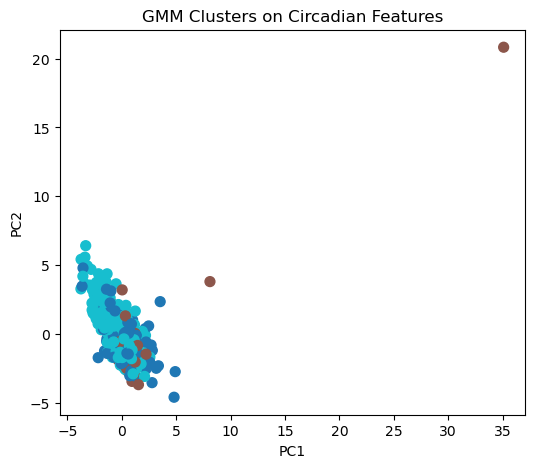

Subjects per GMM cluster: {2: 330, 0: 129, 1: 40}


In [4]:

# 5) Fit GMM
gmm      = GaussianMixture(n_components=3,
                           covariance_type="diag",
                           random_state=0)
labels_gm = gmm.fit_predict(X_scaled)

# 6) 2-D PCA for visualization
pca = PCA(n_components=2, random_state=0)
X2  = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=labels_gm, cmap="tab10", s=50)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("GMM Clusters on Circadian Features")
plt.show()

# 7) Cluster counts
counts = collections.Counter(labels_gm)
print("Subjects per GMM cluster:", dict(counts))

## Cluster interpretation

In [6]:
import pandas as pd
import numpy as np

# assume df, pids and labels_gm from your last run

# 1a) Rebuild the truncated & imputed circadian matrix you used for GMM
#     so we can compute means and variances per subject.
cluster_vars = [
    "steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope",
    "steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std",
    "steps_fitbit_steps_intraday_rapids_mindurationactivebout_night_mean",
    "steps_fitbit_steps_intraday_rapids_avgdurationactivebout_allday_std",
    "steps_fitbit_steps_intraday_rapids_avgdurationactivebout_night_slope",
    "steps_fitbit_steps_intraday_rapids_countepisodeactivebout_night_std",
    "steps_fitbit_steps_intraday_rapids_sumdurationactivebout_evening_slope",
    "screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std",
    "screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope",
]
T = min(df.groupby("pid").size())

records = []
for pid in pids:
    seq = df[df["pid"] == pid][cluster_vars].iloc[:T].copy()
    seq = seq.fillna(seq.mean())     # same imputation as before
    rec = {"pid": pid}
    for var in cluster_vars:
        rec[f"{var}_mean"] = seq[var].mean()
        rec[f"{var}_std"]  = seq[var].std(ddof=0)
    records.append(rec)

subj_stats = pd.DataFrame(records)
subj_stats["cluster"] = labels_gm

cluster_stats = (
    subj_stats
      .groupby("cluster")
      .agg({col: ["mean","std"] 
            for col in subj_stats.columns if col not in ["pid","cluster"]})
)

# Flatten column MultiIndex
cluster_stats.columns = [
    f"{var}_{stat}" 
    for var, stat in cluster_stats.columns
]
display(cluster_stats.round(3))

,steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope_mean_mean,steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope_mean_std,steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope_std_mean,steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope_std_std,steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std_mean_mean,steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std_mean_std,steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std_std_mean,steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std_std_std,steps_fitbit_steps_intraday_rapids_mindurationactivebout_night_mean_mean_mean,steps_fitbit_steps_intraday_rapids_mindurationactivebout_night_mean_mean_std,...,steps_fitbit_steps_intraday_rapids_sumdurationactivebout_evening_slope_std_mean,steps_fitbit_steps_intraday_rapids_sumdurationactivebout_evening_slope_std_std,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std_mean_mean,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std_mean_std,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std_std_mean,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std_std_std,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope_mean_mean,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope_mean_std,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope_std_mean,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope_std_std
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.443,3.125,7.270,3.969,0.558,3.205,1.285,7.855,1.229,0.326,...,5.017,3.394,201.914,89.391,104.837,39.295,0.348,7.048,15.000,8.857
1,0.206,3.274,6.950,3.096,7.512,13.199,16.079,28.483,1.118,0.132,...,4.764,3.392,211.659,75.178,116.968,27.422,0.048,5.459,13.673,9.017
2,-0.956,3.213,6.903,4.307,0.009,0.032,0.020,0.071,1.085,0.088,...,5.544,3.142,218.531,98.096,104.827,43.354,1.584,7.887,16.350,10.112


# Spectral Clustering

Choosing n_clusters = 4

## Finetuning

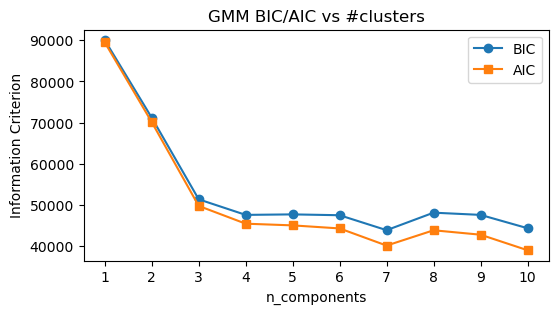

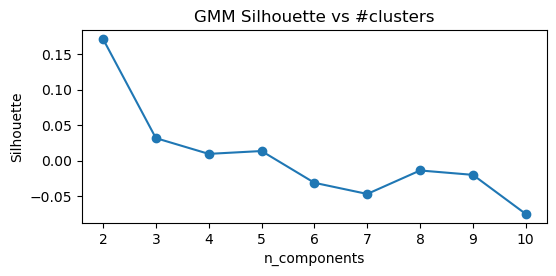

Spectral (RBF) tuning:
 γ=0.001 → {1: 113, 3: 190, 2: 165, 0: 31}
 γ=0.01  → {3: 172, 0: 325, 1: 1, 2: 1}


/Users/kwang/.local/share/mamba/envs/lingam-env/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/kwang/.local/share/mamba/envs/lingam-env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/kwang/.local/share/mamba/envs/lingam-env/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/kwang/.local/share/mamba/envs/lingam-env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


 γ=0.1   → {0: 498, 1: 1}
 γ=1     → {0: 498, 1: 1}


/Users/kwang/.local/share/mamba/envs/lingam-env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 260 with accuracies 
[1.54361412e-06 1.44571883e-05 1.94134135e-05 6.84434580e-06
 1.35214031e-04]
not reaching the requested tolerance 7.4356794357299805e-06.
Use iteration 260 instead with accuracy 
3.549451847731722e-05.

  _, diffusion_map = lobpcg(
/Users/kwang/.local/share/mamba/envs/lingam-env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.54361405e-06 1.44571883e-05 1.94134135e-05 6.84434601e-06
 1.35214031e-04]
not reaching the requested tolerance 7.4356794357299805e-06.
  _, diffusion_map = lobpcg(


 γ=10    → {0: 496, 3: 1, 2: 1, 1: 1}

Spectral (k-NN) tuning:
 n_nb=5  → {1: 175, 3: 312, 0: 6, 2: 6}
 n_nb=10 → {2: 95, 3: 140, 1: 89, 0: 175}
 n_nb=20 → {3: 92, 1: 126, 0: 128, 2: 153}
 n_nb=50 → {2: 106, 3: 117, 0: 135, 1: 141}


In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing    import StandardScaler
from sklearn.mixture           import GaussianMixture
from sklearn.cluster           import SpectralClustering
from sklearn.metrics           import silhouette_score
from sklearn.neighbors         import kneighbors_graph
import matplotlib.pyplot as plt
import collections

# 1) Circadian features & common length T
cluster_vars = [
    "steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope",
    "steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std",
    "steps_fitbit_steps_intraday_rapids_mindurationactivebout_night_mean",
    "steps_fitbit_steps_intraday_rapids_avgdurationactivebout_allday_std",
    "steps_fitbit_steps_intraday_rapids_avgdurationactivebout_night_slope",
    "steps_fitbit_steps_intraday_rapids_countepisodeactivebout_night_std",
    "steps_fitbit_steps_intraday_rapids_sumdurationactivebout_evening_slope",
    "screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std",
    "screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope",
]
T = int(df.groupby("pid").size().min())

# 2) Build high-dim array X_hd, per-subject mean imputation + padding
pids, X_hd = [], []
for pid, g in df.groupby("pid", sort=False):
    seq = g[cluster_vars].iloc[:T].copy()
    seq = seq.fillna(seq.mean())           # impute NaNs]
    seq = seq.fillna(0)
    if len(seq) < T:
        pad = pd.DataFrame([seq.mean().values] * (T - len(seq)),
                           columns=cluster_vars)
        seq = pd.concat([seq, pad], ignore_index=True)
    X_hd.append(seq.to_numpy().flatten())
    pids.append(pid)
X_hd = np.vstack(X_hd)                      # (n_subjects, 4*T)
# and then standardized to X_scaled:
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_hd)

# ── 1) GMM tuning: BIC / AIC curves ──
Ks = range(1, 11)
bic, aic = [], []
for k in Ks:
    gm = GaussianMixture(n_components=k,
                         covariance_type='diag',
                         random_state=0).fit(X_scaled)
    bic.append(gm.bic(X_scaled))
    aic.append(gm.aic(X_scaled))

plt.figure(figsize=(6,3))
plt.plot(Ks, bic, marker='o', label='BIC')
plt.plot(Ks, aic, marker='s', label='AIC')
plt.xticks(Ks)
plt.xlabel("n_components")
plt.ylabel("Information Criterion")
plt.legend()
plt.title("GMM BIC/AIC vs #clusters")
plt.show()

# ── 2) GMM tuning: silhouette scores ──
sil_scores = []
for k in Ks[1:]:
    labels = GaussianMixture(n_components=k,
                             covariance_type='diag',
                             random_state=0) \
             .fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,2.5))
plt.plot(Ks[1:], sil_scores, marker='o')
plt.xticks(Ks[1:])
plt.xlabel("n_components")
plt.ylabel("Silhouette")
plt.title("GMM Silhouette vs #clusters")
plt.show()

# ── 3) Spectral tuning: RBF affinity over a grid of γ ──
print("Spectral (RBF) tuning:")
for gamma in [0.001, 0.01, 0.1, 1, 10]:
    sc = SpectralClustering(n_clusters=4,
                            affinity='rbf',
                            gamma=gamma,
                            assign_labels='kmeans',
                            random_state=0)
    labels = sc.fit_predict(X_scaled)
    print(f" γ={gamma:<5} →", dict(collections.Counter(labels)))

# ── 4) Spectral tuning: k-NN affinity over a grid of n_neighbors ──
print("\nSpectral (k-NN) tuning:")
for n_nb in [5, 10, 20, 50]:
    # build connectivity
    conn = kneighbors_graph(X_scaled, n_neighbors=n_nb,
                            include_self=True)
    conn = 0.5 * (conn + conn.T)
    sc = SpectralClustering(n_clusters=4,
                            affinity='precomputed',
                            assign_labels='kmeans',
                            random_state=0)
    labels = sc.fit_predict(conn)
    print(f" n_nb={n_nb:<2} →", dict(collections.Counter(labels)))


choosing n = 4, gamma = 0.001 and n_nb = 10 and rerun the algorithm

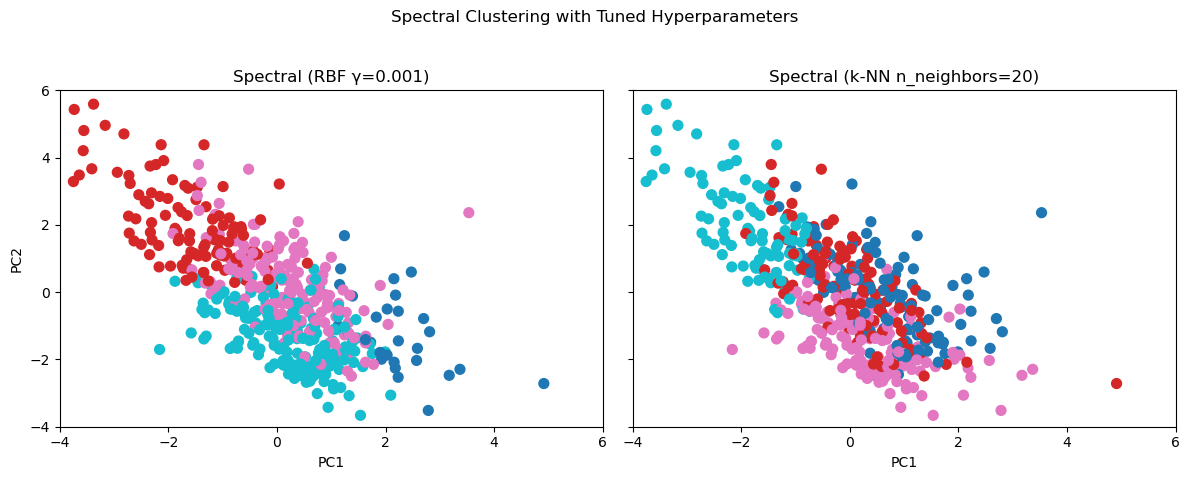

RBF clusters: {1: 113, 3: 190, 2: 165, 0: 31}
k-NN clusters: {3: 92, 1: 126, 0: 128, 2: 153}


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster         import SpectralClustering
from sklearn.neighbors       import kneighbors_graph
from sklearn.decomposition   import PCA
import collections

# ── 1) Build k-NN connectivity for n_neighbors=20 ──
conn = kneighbors_graph(X_scaled, n_neighbors=20,
                        include_self=True)
conn = 0.5 * (conn + conn.T)   # make it symmetric

# ── 2) Spectral Clustering with RBF affinity (gamma=0.001) ──
sc_rbf = SpectralClustering(
    n_clusters    = 4,
    affinity      = 'rbf',
    gamma         = 0.001,
    assign_labels = 'kmeans',
    random_state  = 0
)
labels_rbf = sc_rbf.fit_predict(X_scaled)

# ── 3) Spectral Clustering with precomputed k-NN graph ──
sc_knn = SpectralClustering(
    n_clusters    = 4,
    affinity      = 'precomputed',
    assign_labels = 'kmeans',
    random_state  = 0
)
labels_knn = sc_knn.fit_predict(conn)

# ── 4) 2D embedding for both ──
X2 = PCA(n_components=2, random_state=0) \
       .fit_transform(X_scaled)

# ── 5) Plot side-by-side ──
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

axes[0].scatter(X2[:,0], X2[:,1], c=labels_rbf, cmap="tab10", s=50)
axes[0].set_title("Spectral (RBF γ=0.001)")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")
axes[0].set_xlim(-5, 10)
axes[0].set_ylim(-5, 10)

axes[1].scatter(X2[:,0], X2[:,1], c=labels_knn, cmap="tab10", s=50)
axes[1].set_title("Spectral (k-NN n_neighbors=20)")
axes[1].set_xlabel("PC1")
axes[1].set_xlim(-4, 6)
axes[1].set_ylim(-4, 6)

plt.suptitle("Spectral Clustering with Tuned Hyperparameters")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ── 6) Print cluster sizes ──
print("RBF clusters:", dict(collections.Counter(labels_rbf)))
print("k-NN clusters:", dict(collections.Counter(labels_knn)))


In [21]:
import pandas as pd

# 1) Build a per‐subject summary table of circadian features
cluster_vars = [
    "steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope",
    "steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std",
    "steps_fitbit_steps_intraday_rapids_mindurationactivebout_night_mean",
    "steps_fitbit_steps_intraday_rapids_avgdurationactivebout_allday_std",
    "steps_fitbit_steps_intraday_rapids_avgdurationactivebout_night_slope",
    "steps_fitbit_steps_intraday_rapids_countepisodeactivebout_night_std",
    "steps_fitbit_steps_intraday_rapids_sumdurationactivebout_evening_slope",
    "screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std",
    "screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope",
]
T = int(df.groupby("pid").size().min())

records = []
for pid in pids:
    seq = df[df["pid"] == pid][cluster_vars].iloc[:T].copy()
    seq = seq.fillna(seq.mean())
    rec = {"pid": pid}
    for var in cluster_vars:
        rec[f"{var}_mean"] = seq[var].mean()
        rec[f"{var}_std"]  = seq[var].std(ddof=0)
    records.append(rec)

subj_stats = pd.DataFrame(records)

# 2) Attach both sets of cluster labels
subj_stats["cluster_rbf"] = labels_rbf
subj_stats["cluster_knn"] = labels_knn

# 3) Define a function to aggregate and pretty‐print
def cluster_summary(df, cluster_col):
    agg = df.groupby(cluster_col).agg({
        f"{v}_mean": ["mean","std"] for v in cluster_vars
    } | {
        f"{v}_std": ["mean","std"] for v in cluster_vars
    })
    # flatten columns
    agg.columns = [f"{feat}_{stat}" for feat,stat in agg.columns]
    return agg.round(3)

# 4) Compute summaries
print("=== Spectral (RBF γ=0.001) cluster summaries ===")
cluster_summary(subj_stats, "cluster_rbf")



=== Spectral (RBF γ=0.001) cluster summaries ===


,steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope_mean_mean,steps_fitbit_steps_intraday_rapids_stddurationsedentarybout_morning_slope_mean_std,steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std_mean_mean,steps_fitbit_steps_intraday_rapids_mindurationsedentarybout_allday_std_mean_std,steps_fitbit_steps_intraday_rapids_mindurationactivebout_night_mean_mean_mean,steps_fitbit_steps_intraday_rapids_mindurationactivebout_night_mean_mean_std,steps_fitbit_steps_intraday_rapids_avgdurationactivebout_allday_std_mean_mean,steps_fitbit_steps_intraday_rapids_avgdurationactivebout_allday_std_mean_std,steps_fitbit_steps_intraday_rapids_avgdurationactivebout_night_slope_mean_mean,steps_fitbit_steps_intraday_rapids_avgdurationactivebout_night_slope_mean_std,...,steps_fitbit_steps_intraday_rapids_avgdurationactivebout_night_slope_std_mean,steps_fitbit_steps_intraday_rapids_avgdurationactivebout_night_slope_std_std,steps_fitbit_steps_intraday_rapids_countepisodeactivebout_night_std_std_mean,steps_fitbit_steps_intraday_rapids_countepisodeactivebout_night_std_std_std,steps_fitbit_steps_intraday_rapids_sumdurationactivebout_evening_slope_std_mean,steps_fitbit_steps_intraday_rapids_sumdurationactivebout_evening_slope_std_std,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std_std_mean,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_allday_std_std_std,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope_std_mean,screen_phone_screen_rapids_firstuseafter00unlock_locmap_home_afternoon_slope_std_std
cluster_rbf,,,,,,,,,,,,,,,,,,,,,
0,-0.826,3.549,2.777,9.737,1.567,0.486,1.888,3.381,-0.026,0.171,...,0.371,0.340,1.292,0.807,6.698,3.620,100.354,43.666,18.365,9.283
1,-0.735,4.061,0.077,0.412,1.069,0.090,0.613,0.216,0.003,0.094,...,0.198,0.168,2.031,0.952,6.704,3.379,117.152,47.534,17.785,11.374
2,-1.087,3.166,0.525,3.244,1.088,0.089,0.587,0.223,0.004,0.085,...,0.165,0.136,1.398,0.827,5.361,2.926,108.265,38.310,17.781,9.105
3,-0.401,2.530,1.025,5.331,1.115,0.116,0.555,0.245,-0.002,0.064,...,0.132,0.104,0.892,0.619,4.296,2.962,97.796,37.859,12.412,8.311


In [17]:
print(cluster_summary(subj_stats, "cluster_rbf"))

             SRI_mean_mean  SRI_mean_std  dlmo_proxy_mean_mean  \
cluster_rbf                                                      
0                   82.361        12.249                12.435   
1                   71.974        12.546                 7.755   
2                   78.878        11.296                10.048   
3                   82.090        10.016                11.274   

             dlmo_proxy_mean_std  sigma_bed_mean_mean  sigma_bed_mean_std  \
cluster_rbf                                                                 
0                          5.267                5.996               3.438   
1                          5.578                3.557               2.173   
2                          5.318                5.061               3.164   
3                          5.671                4.529               3.136   

             mid_sleep_mean_mean  mid_sleep_mean_std  SRI_std_mean  \
cluster_rbf                                                          


In [18]:
print("\n=== Spectral (k-NN n_neighbors=10) cluster summaries ===")
cluster_summary(subj_stats, "cluster_knn")


=== Spectral (k-NN n_neighbors=10) cluster summaries ===


,SRI_mean_mean,SRI_mean_std,dlmo_proxy_mean_mean,dlmo_proxy_mean_std,sigma_bed_mean_mean,sigma_bed_mean_std,mid_sleep_mean_mean,mid_sleep_mean_std,SRI_std_mean,SRI_std_std,dlmo_proxy_std_mean,dlmo_proxy_std_std,sigma_bed_std_mean,sigma_bed_std_std,mid_sleep_std_mean,mid_sleep_std_std
cluster_knn,,,,,,,,,,,,,,,,
0,78.903,10.114,11.110,5.096,5.431,3.240,5.487,1.695,9.499,7.109,6.465,3.202,3.191,1.370,0.894,1.062
1,80.009,10.511,9.772,5.451,4.754,3.184,6.095,2.116,10.235,7.428,6.072,3.444,2.958,1.532,1.034,1.276
2,82.913,10.206,11.928,5.666,4.452,3.077,5.610,2.417,8.587,6.655,6.201,3.436,3.095,1.549,0.950,1.306
3,69.912,13.693,6.344,4.962,3.349,1.891,7.036,1.879,13.325,9.321,4.578,3.845,2.525,1.246,1.015,0.826


# Lingam on each cluster

Causal features:


causal_vars = [

    "slp_fitbit_sleep_intraday_rapids_mindurationawakeunifiedmain_afternoon_slope",
    "slp_fitbit_sleep_intraday_rapids_stddurationasleepunifiedmain_afternoon_mean",
    "slp_fitbit_sleep_intraday_rapids_maxdurationawakeunifiedmain_evening_std",
    "slp_fitbit_sleep_intraday_rapids_ratiodurationasleepunifiedwithinmain_night_std",
    "slp_fitbit_sleep_intraday_rapids_ratiodurationawakeunifiedwithinmain_evening_std",
    "slp_fitbit_sleep_summary_rapids_sumdurationafterwakeupmain_allday_slope",
    "slp_fitbit_sleep_summary_rapids_countepisodemain_allday_mean",
    "SRI","dlmo_proxy","sigma_bed","mid_sleep"
]

In [16]:
import numpy as np
import pandas as pd
from collections import defaultdict
from lingam import LongitudinalLiNGAM

def zscore_subject(group: pd.DataFrame) -> pd.DataFrame:
    z = group[vars_all].apply(
        lambda v: (v - v.mean()) / (v.std(ddof=0) or 1.0)
    )
    return z.fillna(0)                   # any residual NaN → 0
df_z = df.groupby("pid", sort=False).apply(zscore_subject).reset_index(level=0)

import numpy as np
import pandas as pd
from collections import defaultdict
from lingam import LongitudinalLiNGAM

# ── 0) Define your causal variables ──
causal_vars = [
    "slp_fitbit_sleep_intraday_rapids_mindurationawakeunifiedmain_afternoon_slope",
    "slp_fitbit_sleep_intraday_rapids_stddurationasleepunifiedmain_afternoon_mean",
    "slp_fitbit_sleep_intraday_rapids_maxdurationawakeunifiedmain_evening_std",
    "slp_fitbit_sleep_intraday_rapids_ratiodurationasleepunifiedwithinmain_night_std",
    "slp_fitbit_sleep_intraday_rapids_ratiodurationawakeunifiedwithinmain_evening_std",
    "slp_fitbit_sleep_summary_rapids_sumdurationafterwakeupmain_allday_slope",
    "slp_fitbit_sleep_summary_rapids_countepisodemain_allday_mean",
    "SRI","dlmo_proxy","sigma_bed","mid_sleep","PHQ4_dev"
]

# (You can keep your existing z-scoring over vars_all if you like,
#  but here we only pull the causal_vars out of df_z.)

# 1) Parameters
T_target = 10
n_lags   = 2
thr      = 0.05

# 2) Map clusters → pids
cluster_to_pids = defaultdict(list)
for pid, lab in zip(pids, labels_rbf):
    cluster_to_pids[lab].append(pid)

cluster_models = {}

# 3) Build & fit per-cluster models using only causal_vars
for lab, cl_pids in cluster_to_pids.items():
    N_cl   = len(cl_pids)
    p      = len(causal_vars)
    X_t_cl = np.zeros((T_target, N_cl, p), dtype=float)
    
    for j, pid in enumerate(cl_pids):
        # only pull causal_vars here
        seq = df_z[df_z["pid"] == pid][causal_vars].to_numpy()
        L   = seq.shape[0]
        mu  = np.nanmean(seq, axis=0)
        
        if L >= T_target:
            seq_t = seq[-T_target:]               # last T_target rows
        else:
            pad   = np.tile(mu, (T_target - L, 1))
            seq_t = np.vstack([pad, seq])
        
        X_t_cl[:, j, :] = seq_t
    
    # fit LongitudinalLiNGAM on just those p variables
    m = LongitudinalLiNGAM(n_lags=n_lags, random_state=0)
    m.fit(X_t_cl)
    cluster_models[lab] = m
    print(f"Cluster {lab}: subjects={N_cl}, shape={X_t_cl.shape}")

# 4) Inspect direct → PHQ4_dev for each cluster
target = causal_vars.index("PHQ4_dev")

for lab, m in cluster_models.items():
    B0 = m.adjacency_matrices_[T_target-1, 0]   # instantaneous
    B1 = m.adjacency_matrices_[T_target-1, 1]   # lag-1
    print(f"\nCluster {lab} direct → PHQ4_dev (|w| ≥ {thr}):")
    for lag, B in enumerate([B0, B1]):
        idx = np.where(np.abs(B[target, :]) > thr)[0]
        for i in idx:
            var = causal_vars[i]
            print(f"  lag={lag}: {var} → PHQ4_dev  (w={B[target,i]:.3f})")


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_2402/697019278.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_z = df.groupby("pid", sort=False).apply(zscore_subject).reset_index(level=0)


Cluster 1: subjects=113, shape=(10, 113, 12)
Cluster 3: subjects=190, shape=(10, 190, 12)
Cluster 2: subjects=165, shape=(10, 165, 12)
Cluster 0: subjects=31, shape=(10, 31, 12)

Cluster 1 direct → PHQ4_dev (|w| ≥ 0.05):
  lag=1: slp_fitbit_sleep_intraday_rapids_maxdurationawakeunifiedmain_evening_std → PHQ4_dev  (w=0.254)
  lag=1: slp_fitbit_sleep_intraday_rapids_ratiodurationawakeunifiedwithinmain_evening_std → PHQ4_dev  (w=0.100)
  lag=1: slp_fitbit_sleep_summary_rapids_countepisodemain_allday_mean → PHQ4_dev  (w=0.080)
  lag=1: dlmo_proxy → PHQ4_dev  (w=-0.142)
  lag=1: sigma_bed → PHQ4_dev  (w=-0.265)
  lag=1: mid_sleep → PHQ4_dev  (w=-0.068)
  lag=1: PHQ4_dev → PHQ4_dev  (w=-0.105)

Cluster 3 direct → PHQ4_dev (|w| ≥ 0.05):
  lag=1: slp_fitbit_sleep_intraday_rapids_mindurationawakeunifiedmain_afternoon_slope → PHQ4_dev  (w=-0.091)
  lag=1: slp_fitbit_sleep_intraday_rapids_stddurationasleepunifiedmain_afternoon_mean → PHQ4_dev  (w=-0.247)
  lag=1: slp_fitbit_sleep_intraday_rapids_

In [27]:
corr = df_z.groupby("pid")["SRI"].mean().corr(
           df_z.groupby("pid")["PHQ4_dev"].mean()
       )
print("Across-subject mean SRI ↔ mean PHQ4_dev:", corr)

Across-subject mean SRI ↔ mean PHQ4_dev: 0.019150925690689557


In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df_z[["SRI","mid_sleep","sigma_bed","dlmo_proxy"]].dropna()
X = (X - X.mean()) / X.std()   # standardize
vif = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)
print(vif)

SRI           1.360384
mid_sleep     1.121384
sigma_bed     1.323447
dlmo_proxy    1.051979
dtype: float64
